# Validate forward model with Fourier Convolution

/tmp/ipykernel_622664/530063389.py:29: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  psf = psf.resize((128, 128), Image.BICUBIC)


tensor([[1., 1., 1.]])
ref tensor(0.9922) tensor(-1.) tensor(-0.0757)


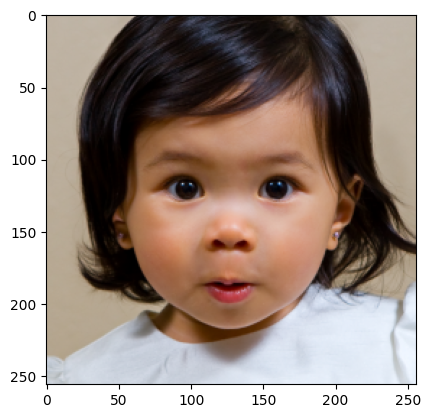

ref tensor(1.) tensor(0.) tensor(0.4640)
meas tensor(0.0014) tensor(0.0001) tensor(0.0007)


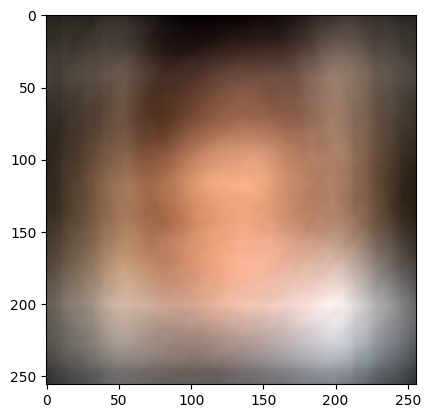

In [3]:
from data.dataloader import get_dataset, get_dataloader   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import yaml
from PIL import Image
import numpy as np
import torch
from util.img_utils import clear_color

def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config
task_config = load_yaml('./configs/diffuser_cam_config.yaml')

# Prepare dataloader
data_config = task_config['data']
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)


   

# Load PSF
psf_path = './data/psf_sample.jpg'
psf = Image.open(psf_path)
psf = psf.resize((128, 128), Image.BICUBIC)
psf = np.array(psf, dtype=np.float32)
bg = np.mean(psf[5:15,5:15])
psf -= bg
psf = np.clip(psf, 0, None)
psf /= np.sum(psf)
psf *= 3

psf = torch.tensor(psf)
psf = psf.permute(2, 0, 1)
psf = psf.view(1, 3, psf.shape[1], psf.shape[2]) 

plt.imsave('psf.png', clear_color(psf))

# calculate the mean of each channel
mean = torch.sum(psf, dim=(2, 3))
print(mean)


def pad(x, padded_shape):
    M, N = x.shape[2:]
    pad0 = (padded_shape[0]-M)//2
    pad1 = (padded_shape[1]-N)//2
    pad_size = (pad1, pad1, pad0, pad0)
    padding = torch.nn.ZeroPad2d(pad_size)
    x_pad = padding(x)
    crop_shape = [pad0, pad1, pad0+M, pad1+N]
    return x_pad, crop_shape

def crop(x, crop_shape):
    x_crop = x[:,:,crop_shape[0]:crop_shape[2], crop_shape[1]:crop_shape[3]]
    return x_crop

def forward(x, psf):
    M, N = x.shape[2:]
    padded_shape = [next_pow2(2*n - 1) for n in [M,N]]
    x_pad, crop_shape = pad(x, padded_shape)
    psf_pad, _ = pad(psf, padded_shape)
     # Perform FFT on both x and psf
    x_f = torch.fft.fft2(x_pad, dim=(-2, -1), norm="ortho")
    psf_f = torch.fft.fft2(psf_pad, dim=(-2, -1))

    # Convolve and transform back
    y_f = psf_f * x_f
    y_conv = torch.fft.ifft2(y_f, dim=(-2, -1))
    y_conv = torch.abs(torch.fft.ifftshift(y_conv, dim=(-2, -1)))
    # y = y/torch.max(torch.flatten(y))
    return crop(y_conv, crop_shape)

def next_pow2(n):
    return int(2**np.ceil(np.log2(n)))


for i, ref_img in enumerate(loader): 
    print('ref', ref_img.max(), ref_img.min(), ref_img.mean()) 
    # ref_img = ref_img/torch.max(torch.flatten(ref_img))
    # print(ref_img[0].max(), ref_img[0].min())
    # plt.imshow(ref_img[0].permute(1, 2, 0))
    # plt.show()
    
    # psf = psf/torch.max(torch.flatten(psf))
    # plt.imshow(psf[0].permute(1, 2, 0))
    # plt.show()
    
    img = clear_color(ref_img)
    plt.imshow(img)
    plt.show()
    ref_img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)
    y = forward(ref_img, psf)
    
    print('ref', ref_img.max(), ref_img.min(), ref_img.mean()) 
    
    print('meas', y.max(), y.min(), y.mean())
    img = clear_color(y)
    plt.imshow(img)
    plt.show()
    break

tensor(1.) tensor(0.) tensor(0.4640)
tensor(0.7197) tensor(0.0598) tensor(0.3571)


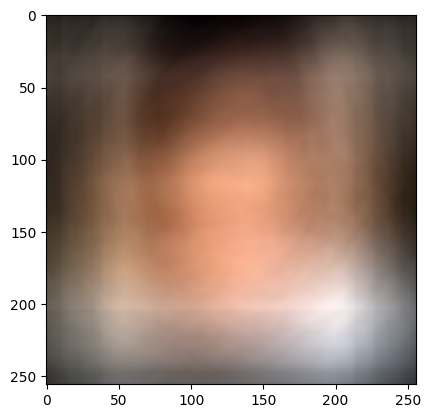

In [4]:
from guided_diffusion.measurements import DiffuserCamOperator
print(ref_img.max(), ref_img.min(), ref_img.mean()) 
diffuser_cam = DiffuserCamOperator(psf_path, 'cpu')
y = diffuser_cam.forward(ref_img)
print(y.max(), y.min(), y.mean())
plt.imsave('meas.png', clear_color(y))

img = clear_color(y)
plt.imshow(img)
plt.show()


# Deconvolution (based on optimization)

In [9]:
# use autograd to perform deconvolution
from guided_diffusion.measurements import DiffuserCamOperator
from tqdm import tqdm


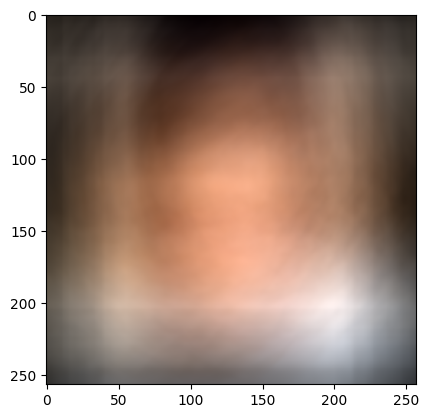

100%|██████████| 2000/2000 [00:17<00:00, 112.32it/s]


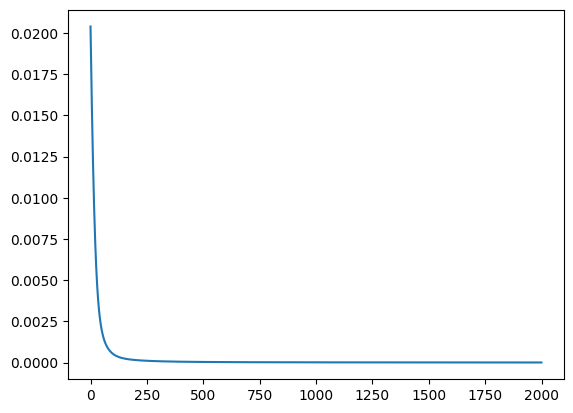

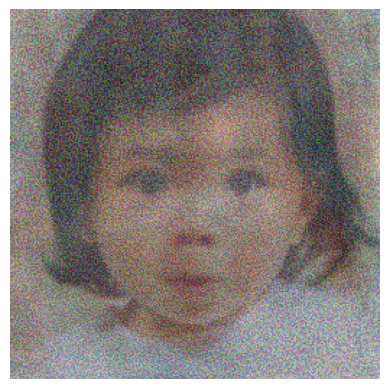

In [13]:
device = 'cuda:0'
diffuser_cam = DiffuserCamOperator(psf_path, device)
ref_img = ref_img.to(device)
y = diffuser_cam.forward(ref_img)
img = clear_color(y)
plt.imshow(img)
plt.show()

recon = torch.rand_like(ref_img, device=device)
recon.requires_grad = True
optimizer = torch.optim.Adam([recon], lr=0.005)
losses = []
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(diffuser_cam.forward(recon), y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.show()
plt.imshow(clear_color(recon))
plt.axis('off')
plt.show()